In [24]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from dataclasses import dataclass, field
from typing import List, Optional, Tuple
import numpy as np


crater_dtype = np.dtype([
    ('radius', 'f4'),          # float32 for crater radius
    ('y_position', 'f4'),      # float32 for y-axis position
    ('time_formed', 'i4'),     # int32 for timestamp
    ('depth', 'f4'),           # float32 for crater depth
])
    
    
# Definition of the simulation state through a dataclass
@dataclass
class EDMState:
    # Time tracking
    time: int = 0 # Current time from start of simulation
    time_since_servo: int = 0 # Time since last servo action
    time_since_open_voltage: int = 0  # Time since last voltage was applied
    time_since_spark_ignition: int = 0 # Time since last spark was ignited
    time_since_spark_end: int = 0 # Time since last spark ended
    
    
    # Electrical state variables
    voltage: Optional[float] = None
    current: Optional[float] = None
    
    # Generator control state variables
    target_voltage: Optional[float] = None
    peak_current: Optional[float] = None
    OFF_time: Optional[float] = None
    ON_time: Optional[float] = None

    # Workpiece state variables
    
    workpiece_position: float = 0 # Current position of the workpiece
    
    # Wire state variables
    wire_position: float = 0.0 # Current position of the wire
    wire_velocity: float = 0.0 # Current velocity of the wire
    wire_unwinding_velocity = 0.2 # Unwinding velocity of the wire in micrometers per microsecond (microns/μs -- mm/ms .. m/s)
    
    
    craters_on_wire: np.ndarray = field(default_factory=lambda: np.array([], dtype=crater_dtype)) # List of craters on the wire (position, time, crater size, etc.)
    
    wire_average_temperature: float = 0.0 # Average temperature of the wire across the length
    
    
    # Spark state variables
    
    # Tuple to track current spark status (state, y-location, duration)
    # state: 0=No event, 1=Spark formation, -1=Short circuit, -2=Rest period
    # y_location: Position along wire length where spark is occurring (None if no spark)
    # duration: How many timesteps the current spark state has existed
    spark_status: List[Optional[float]] = field(default_factory=lambda: [0, None, 0])

    
    # Dielectric state variables
    
    dielectric_conductivity: float = 0.0 # Conductivity of the dielectric
    dielectric_temperature: float = 0.0 # Temperature of the dielectric
    debris_concentration: float = 0.0 # Concentration of debris in the dielectric
    dielectric_flow_rate: float = 0.0 # Flow rate of the dielectric
    
    # Servo state variables
    
    target_delta: float = 0.0 # Target change in position for the servo in the linear axis. This is the main servo control signal.
    
    # Process state
    is_wire_broken: bool = False
    is_wire_colliding: bool = False
    is_target_distance_reached: bool = False

# Definition of the base class for all EDM simulation modules
class EDMModule:
    """Base class for all EDM simulation modules"""
    def __init__(self, env):
        self.env = env

    def update(self, state: EDMState) -> None:
        pass
    
    
# Definition of the simulation modules 

## Ignition Module
class IgnitionModule(EDMModule):
    def __init__(self, env):
        super().__init__(env)
        self.lambda_cache = {}  # Cache for lambda values
        
    def update(self, state: EDMState) -> None:
        
        # First, unpack the generator control state
        target_voltage = state.target_voltage
        peak_current = state.peak_current
        ON_time = state.ON_time if state.ON_time is not None else 3  # Default to 3
        OFF_time = state.OFF_time if state.OFF_time is not None else 80  # Default to 80
        
        # Check for physical short circuit (wire touching workpiece)
        if state.wire_position >= state.workpiece_position:
            state.spark_status = [-1, None, 0]
            state.voltage = 0
            state.current = state.peak_current
            return

        # Check spark status in the previous timestep
        spark_state, spark_location, spark_duration = state.spark_status
        
        # Check for ionized channel short circuit
        if state.ionized_channel is not None:
            y_loc, time_remaining = state.ionized_channel
            # Treat ionized channel as a short circuit
            state.spark_status = [-1, y_loc, 0]
            state.voltage = 0
            state.current = state.peak_current
            return
            
        # Check for debris-induced short circuit
        if self.env.np_random.random() < state.debris_concentration * 0.1: # Scale factor of 0.1 for probability
            state.spark_status = [-1, None, 0]
            state.voltage = 0 
            state.current = state.peak_current
            return
        
        
        # Suppose spark is already present, maintain it until current is cut
        if spark_state == 1: # If spark is happening
            state.spark_status = [1, spark_location, spark_duration + 1] # Increment counter
            if state.spark_status[2] >= ON_time: # End of spark duration
                state.spark_status[0] = -2 # Start rest period
                state.current = 0
                state.voltage = 0
            else:
                state.current = peak_current
                state.voltage = target_voltage * 0.3
            return
        
        if spark_state == -2: # If in rest period
            state.spark_status = [-2, None, spark_duration + 1]
            if state.spark_status[2] >= OFF_time + ON_time:  # End of rest period
                state.spark_status = [0, None, 0]
                state.voltage = target_voltage
                state.current = 0
            return
        
        if spark_state == 0: # No spark happening and not in rest period
            state.voltage = target_voltage
            state.current = 0
            # Calculate probability of new spark formation
            p_ignition = self._get_spark_conditional_probability(state)
    
            # Sample from probability distribution
            if self.env.np_random.random() < p_ignition:
                # Ignition occurs - randomly choose location along wire height
                spark_location = self.env.np_random.uniform(0, self.env.workpiece_height)
                state.spark_status = [1, spark_location, 0]
                state.voltage = state.target_voltage * 0.3  # Voltage drops during discharge
                state.current = state.peak_current
            else:
                # No ignition
                state.spark_status = [0, None, 0]
                state.voltage = state.target_voltage
                state.current = 0
    
    def _get_spark_conditional_probability(self, state):
        """ Calculate the conditional probability of sparking at a given microsecond,
        given that it has not sparked yet since the last voltage rise."""
        # In the case of the exponential distribution, the conditional
        # probability is just lambda
        return self._get_lambda(state)
    
    def _get_lambda(self, state):
        gap_distance = abs(state.workpiece_position - state.wire_position)
        # Check cache first
        if gap_distance in self.lambda_cache:
            return self.lambda_cache[gap_distance]
        # Calculate new lambda value and cache it
        lambda_value = np.log(2)/(0.48*gap_distance*gap_distance - 3.69*gap_distance + 14.05)
        self.lambda_cache[gap_distance] = lambda_value
        
        return lambda_value

## Material Removal Module
class MaterialRemovalModule(EDMModule):
    # TODO: Add crater formation and removal rate based on spark energy
    def update(self, state):
        # Only remove material if there is an active spark that just started
        if state.spark_status[0] == 1 and state.spark_status[2] == 0:
            # Remove a constant amount of material by moving the workpiece position
            # away from the wire by a small fixed increment
            removal_rate = 0.01  # mm per spark
            state.workpiece_position += removal_rate

## Dielectric Module
class DielectricModule(EDMModule):
    def __init__(self, env):
        super().__init__(env)
        # Dielectric state variables
        self.dielectric_temp = 293.15  # Dielectric temperature in K
        self.debris_concentration = 0.0  # Debris concentration (0-1) 
        self.flow_rate = 1.0  # Normalized flow rate (0-1)
        self.ionized_channel = None  # (y_location, time_remaining) or None
        
        # Model parameters
        self.beta = 1e-3  # Debris concentration increase per mm^3 of crater volume
        self.gamma = 5e-4  # Base debris decay rate per microsecond at flow_rate=1
        self.tau_deionization = 6  # Deionization time in microseconds
        
    def update(self, state):
        # Update dielectric temperature
        state.dielectric_temperature = self.dielectric_temp
        
        # Handle debris concentration
        # Add debris if there was a spark that just started
        if state.spark_status[0] == 1 and state.spark_status[2] == 0:
            # Get crater volume from material removal module (placeholder value for now)
            crater_volume = 0.1  # mm^3
            self.debris_concentration = min(1.0, 
                self.debris_concentration + self.beta * crater_volume)
            
            # Create new ionized channel
            self.ionized_channel = (state.spark_status[1], self.tau_deionization)
            
        # Update ionized channel state
        if self.ionized_channel:
            y_loc, time_remaining = self.ionized_channel
            if time_remaining > 0:
                self.ionized_channel = (y_loc, time_remaining - 1)
            else:
                self.ionized_channel = None
                
        # Clear debris based on flow rate (exponential decay)
        self.debris_concentration *= (1 - self.gamma * self.flow_rate)
        self.debris_concentration = max(0.0, self.debris_concentration)
        
        # Update state variables
        state.debris_concentration = self.debris_concentration
        state.flow_rate = self.flow_rate
        state.ionized_channel = self.ionized_channel
        
## Wire Module
class WireModule(EDMModule):
    """Module for simulating wire behavior including thermal and mechanical properties."""
    
    def __init__(self, env):
        super().__init__(env)
        # Material properties
        self.wire_resistivity = 7.0e-8  # Resistivity of brass (ohm*m)
        self.wire_specific_heat = 380  # Specific heat of brass (J/kg*K)
        self.wire_density = 8400  # Density of brass (kg/m^3)
        self.wire_thermal_conductivity = 120  # Thermal conductivity of brass (W/m*K)
        self.wire_melting_point = 1200  # Melting point of brass (K)
        
        # Thermal interaction properties
        self.heat_transfer_coeff = 1000  # Heat transfer coefficient to dielectric (W/m^2*K)
        self.ambient_temp = 293.15  # Ambient temperature (K)
        
        # Geometry and discretization
        self.wire_segment_length = 0.1e-3  # Length of each wire segment (m)
        self.num_segments = int((env.workpiece_height/1000) / self.wire_segment_length)
        
        # Pre-calculate constant segment properties
        wire_radius = env.wire_diameter / 2000  # Convert mm to m and divide by 2 for radius
        self.segment_volume = np.pi * wire_radius**2 * self.wire_segment_length  # Volume in m^3
        self.segment_mass = self.wire_density * self.segment_volume  # Mass in kg
        self.segment_surface_area = np.pi * (env.wire_diameter/1000) * self.wire_segment_length  # Surface area in m^2
        
        # Initialize temperature array
        self.wire_temperature = np.full(self.num_segments, self.ambient_temp, dtype=float)
        
        # Thermal simulation constants
        self.thermal_diffusivity = self.wire_thermal_conductivity / (self.wire_density * self.wire_specific_heat)
        
        # Safety checks
        self._validate_parameters()

    def _validate_parameters(self):
        """Validate initialization parameters to ensure physical consistency."""
        if self.wire_segment_length <= 0:
            raise ValueError("Wire segment length must be positive")
        if self.num_segments <= 0:
            raise ValueError("Number of segments must be positive")
        
        # Check CFL condition for thermal diffusion stability
        dt_max = 0.5 * self.wire_segment_length**2 / self.thermal_diffusivity
        # Convert environment's microsecond timestep to seconds
        if (self.env.dt * 1e-6) > dt_max:  # Fixed unit conversion
            raise ValueError(f"Timestep too large for stable thermal diffusion. Must be <= {dt_max:.2e} seconds")

    def update(self, state: EDMState) -> None:
        """Update the wire state for one timestep."""
        dt = self.env.dt  # Timestep in microseconds
        
        # --- Heat generation from spark ---
        self._process_spark_heating(state, dt)
        
        # --- Heat dissipation to dielectric (Convection) ---
        self._process_convection(dt)
        
        # --- Heat conduction along wire ---
        self._process_conduction(dt)
        
        # --- Wire movement (introducing fresh wire) ---
        self._process_wire_movement()
        
        # --- Update state variables ---
        state.wire_average_temperature = np.mean(self.wire_temperature)
        
        # --- Check for wire breakage ---
        if np.any(self.wire_temperature > self.wire_melting_point):
            state.is_wire_broken = True
            print("Wire broken due to overheating!")  # For debugging

    def _process_spark_heating(self, state: EDMState, dt: float) -> None:
        """Process heating from electrical discharge."""
        spark_status = state.spark_status
        
        if spark_status[0] == 1 and spark_status[1] is not None:
            spark_location_y = spark_status[1]
            spark_duration = dt
            
            # Use actual values if available, otherwise use target values
            voltage = state.voltage if state.voltage is not None else state.target_voltage
            current = state.current if state.current is not None else state.peak_current
            
            if voltage is not None and current is not None:
                spark_energy = voltage * current * spark_duration
                segment_index = int(spark_location_y / self.wire_segment_length)
                
                if 0 <= segment_index < self.num_segments:
                    temp_increase = spark_energy / (self.segment_mass * self.wire_specific_heat)
                    self.wire_temperature[segment_index] += temp_increase

    def _process_convection(self, dt: float) -> None:
        """Process heat transfer to dielectric fluid."""
        # Vectorized calculation for all segments
        temp_difference = self.wire_temperature - self.ambient_temp
        heat_loss = self.heat_transfer_coeff * self.segment_surface_area * temp_difference * dt
        temp_decrease = heat_loss / (self.segment_mass * self.wire_specific_heat)
        self.wire_temperature -= temp_decrease

    def _process_conduction(self, dt: float) -> None:
        """Process heat conduction along the wire length."""
        # Using vectorized operations for better performance
        # Central difference method for interior points
        temp = self.wire_temperature
        diffusion_factor = self.thermal_diffusivity * dt / (self.wire_segment_length**2)
        
        # Compute temperature changes for all interior points at once
        interior_changes = diffusion_factor * (
            np.roll(temp, -1)[1:-1] +  # Forward neighbors
            np.roll(temp, 1)[1:-1] -   # Backward neighbors
            2 * temp[1:-1]             # Current points
        )
        
        # Update interior temperatures
        self.wire_temperature[1:-1] += interior_changes
        
        # Boundary conditions: assume ends maintain ambient temperature
        self.wire_temperature[0] = self.ambient_temp
        self.wire_temperature[-1] = self.ambient_temp

    def _process_wire_movement(self) -> None:
        """Process wire movement and temperature effects."""
        # Shift temperatures down (wire moves down)
        self.wire_temperature = np.roll(self.wire_temperature, -1)
        # New wire entering from top is at ambient temperature
        self.wire_temperature[-1] = self.ambient_temp

## Mechanics Module
class MechanicsModule(EDMModule):
    def __init__(self, env):
        super().__init__(env)
        # Initialize servo dynamics state for workpiece movement
        self.velocity = 0.0  # Current servo velocity (workpiece movement)
        self.omega_n = 1500.0  # Natural frequency (rad/s)
        self.zeta = 1.0        # Damping ratio (critically damped)
        self.max_accel = 5e6   # Maximum acceleration (µm/s^2)

    def update(self, state):
        """
        Update the mechanical state of the workpiece using a second-order servo dynamic model:
            x'' + 2ζωₙ x' + ωₙ² (x - x_target) = 0
        where:
            x is the current workpiece position (state.workpiece_position),
            x_target is the commanded target position (state.target_delta),
            and the integration is performed with Euler's method.
        """
        # Convert timestep from microseconds to seconds
        dt_sec = self.env.dt * 1e-6
        
        # Retrieve current position and target
        x = state.workpiece_position
        x_target = state.target_delta
        
        # Compute acceleration based on servo dynamics
        accel = -2.0 * self.zeta * self.omega_n * self.velocity - self.omega_n**2 * (x - x_target)
        
        # Clip the acceleration to ensure physical plausibility
        accel = np.clip(accel, -self.max_accel, self.max_accel)
        
        # Update velocity and position using Euler integration
        self.velocity += accel * dt_sec
        x_new = x + self.velocity * dt_sec
        
        # Update the workpiece position in state
        state.workpiece_position = x_new

# Definition of the EDM environment
class WireEDMEnv(gym.Env):    
    metadata = {"render_modes": ["human"], "render_fps": 300}
    
    def __init__(self, render_mode=None):
        self.render_mode = render_mode
        # Simulation parameters
        ## Internal timestep parameters
        self.dt = 1 # Base timestep (1μs)
        self.servo_interval = 1000 # Servo interval (1ms)
        
        ## Process configuration
        ### Workpiece physical properties
        self.workpiece_height = 10 # Height of workpiece (mm)
        self.workpiece_material = 'steel' # Material of workpiece
        #...
        
        ### Wire physical properties
        self.wire_material = 'brass'
        self.wire_diameter = 0.25 # Diameter of wire (mm)
        #...
        
        ### Dielectric physical properties
        self.dielectric_material = 'deionized water'
        
        self.state = EDMState() # Initialize state of the simulation
        
        self.ignition_module = IgnitionModule(self)
        self.material_removal_module = MaterialRemovalModule(self)
        self.dielectric_module = DielectricModule(self)
        self.wire_module = WireModule(self)
        self.mechanics_module = MechanicsModule(self)
        
        self.action_space = spaces.Dict({
            'servo': spaces.Box(
                low=np.array([-1.0]),
                high=np.array([1.0]),
                dtype=np.float32
            ),
            'generator_control': spaces.Dict({
                'target_voltage': spaces.Box(
                    low=np.array([0.0]),
                    high=np.array([200.0]),  # Placeholder max voltage
                    dtype=np.float32
                ),
                'peak_current': spaces.Box(
                    low=np.array([0.0]),
                    high=np.array([100.0]),  # Placeholder max current
                    dtype=np.float32
                ),
                'ON_time': spaces.Box(
                    low=np.array([0.0]),
                    high=np.array([5.0]),  # Placeholder max on time
                    dtype=np.float32
                ),
                'OFF_time': spaces.Box(
                    low=np.array([0.0]),
                    high=np.array([100.0]),  # Placeholder max off time
                    dtype=np.float32
                )
            })
        })
    
    def _check_termination(self):
        # Check for wire breakage
        if self.state.wire_position > self.workpiece_height:
            self.state.is_wire_broken = True
            return True
        
        # Check for target distance reached
        if self.state.workpiece_position >= self.state.target_delta:
            self.state.is_target_distance_reached = True
            return True
        
        return False
    
    def _get_obs(self):
        return None
        
    def _calculate_reward(self):
        return 0
    
    def step(self, action):
        # Track if this is a control step (every 1ms / 1000μs)
        is_control_step = self.state.time_since_servo >= self.servo_interval
        
        # Only process actions on control steps
        if is_control_step:
            self.state.target_delta = action['servo'][0]
            self.state.target_voltage = action['generator_control']['target_voltage'][0]
            self.state.peak_current = action['generator_control']['peak_current'][0]
            self.state.ON_time = action['generator_control']['ON_time'][0]  # Add these two lines
            self.state.OFF_time = action['generator_control']['OFF_time'][0]
            self.state.time_since_servo = 0  # Reset timer
        
        # Sequential process updates
        self.ignition_module.update(self.state)
        self.material_removal_module.update(self.state)
        self.dielectric_module.update(self.state)
        self.wire_module.update(self.state)
        if self.state.is_wire_broken:
            # If the wire is broken, return immediately
            return None, 0, True, False, {'wire_broken': True}
        self.mechanics_module.update(self.state)
        
        # Update time trackers
        self.state.time += self.dt
        self.state.time_since_servo += self.dt
        self.state.time_since_open_voltage += self.dt
        
        if self.state.spark_status[0] == 1:
            self.state.time_since_spark_ignition += self.dt
            self.state.time_since_spark_end = 0
        else:
            self.state.time_since_spark_end += self.dt
            self.state.time_since_spark_ignition = 0
        
        # Only return meaningful observations and calculate rewards on control steps
        if is_control_step:
            observation = self._get_obs()
            reward = self._calculate_reward()
            self.previous_target_current = self.state.peak_current
        else:
            observation = None
            reward = 0
        
        terminated = self._check_termination()
        truncated = False
        
        info = {
            'wire_broken': self.state.is_wire_broken,
            'target_reached': self.state.is_target_distance_reached,
            'spark_status': self.state.spark_status[0],
            'time': self.state.time,
            'is_control_step': is_control_step
        }
        
        return observation, reward, terminated, truncated, info


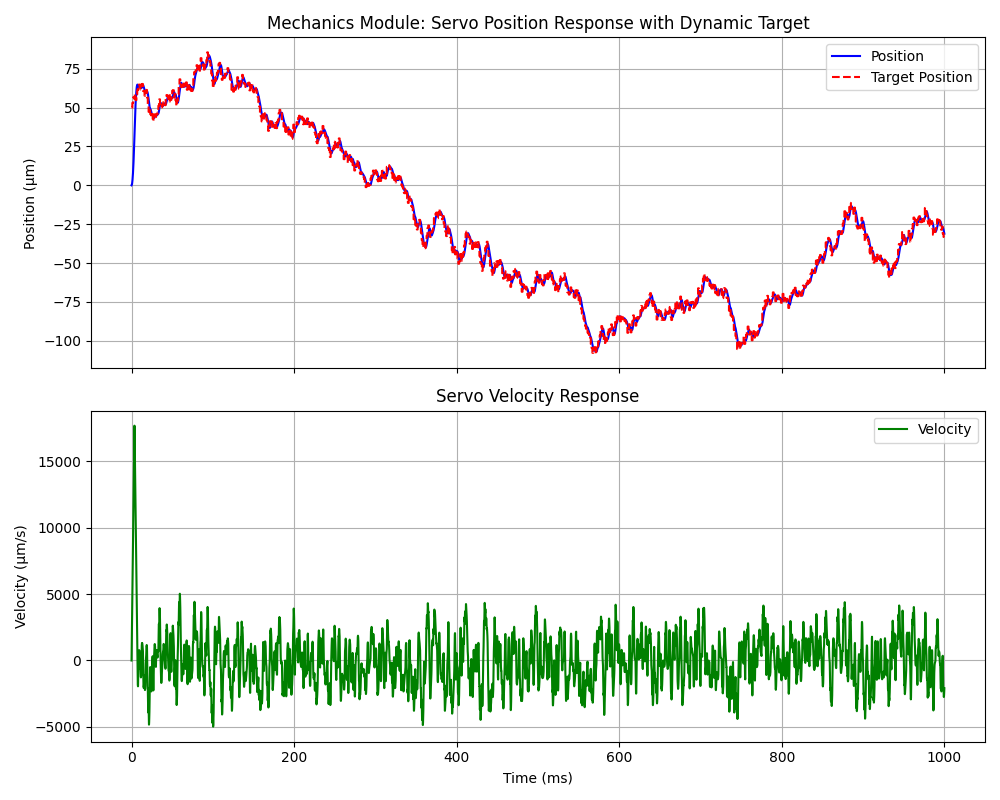

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
# Test cell for Mechanics Module servo dynamics with dynamic target updates.
# The servo dynamics follow the second-order differential equation:
#   x'' + 2ζωₙ x' + ωₙ² (x - x_d) = 0
# where x is the current position, x_d is the target (commanded) position,
# ωₙ is the natural frequency, and ζ is the damping ratio.
#
# In this simulation, every millisecond the target distance is modified by a random
# increment uniformly drawn from the range [-5, 5] micrometers.

# Simulation parameters
omega_n = 1500.0      # Natural frequency in rad/s - typical for precision EDM servos
zeta = 1.0            # Critically damped system (no overshoot)
initial_target = 50.0 # Initial target position in micrometers

# Initial conditions
x = 0.0               # Initial position (in micrometers)
v = 0.0               # Initial velocity (in micrometers per second)
current_target = initial_target  # Current target position

dt = 1e-6             # Integration timestep (1 microsecond)
T_total = 1        # Total simulation time in seconds (10 ms)
n_steps = int(T_total / dt)

# Arrays to record simulation data
time_arr = np.zeros(n_steps)
pos_arr = np.zeros(n_steps)
vel_arr = np.zeros(n_steps)
target_arr = np.zeros(n_steps)  # Records target position over time
max_accel = 5 *10**6  # Maximum acceleration in µm/s²
for i in range(n_steps):
    t = i * dt
    # Update the target position every millisecond (every 1000 steps)
    if i % 1000 == 0:
        if i != 0:
            # Increment the target by a random value uniformly drawn from [-5, 5] micrometers
            current_target += np.random.uniform(-5, 5)
    target_arr[i] = current_target

    time_arr[i] = t
    pos_arr[i] = x
    vel_arr[i] = v

    # Compute acceleration using the servo dynamics:
    # a = -2ζωₙ*v - ωₙ²*(x - current_target)
    a = -2 * zeta * omega_n * v - (omega_n ** 2) * (x - current_target)
    a = np.clip(a, -max_accel, max_accel)
    # Euler integration updates
    v = v + a * dt
    x = x + v * dt

# Plot the position and velocity responses along with the dynamic target
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot Position vs Time (time in milliseconds)
ax1.plot(time_arr * 1e3, pos_arr, label="Position", color='b')
ax1.step(time_arr * 1e3, target_arr, label="Target Position", color='r', linestyle='--', where='post')
ax1.set_ylabel("Position (µm)")
ax1.set_title("Mechanics Module: Servo Position Response with Dynamic Target")
ax1.legend()
ax1.grid(True)

# Plot Velocity vs Time
ax2.plot(time_arr * 1e3, vel_arr, label="Velocity", color='g')
ax2.set_xlabel("Time (ms)")
ax2.set_ylabel("Velocity (µm/s)")
ax2.set_title("Servo Velocity Response")
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import time
import numpy as np
%matplotlib widget
env = WireEDMEnv()
env.state.workpiece_position = 10
env.state.wire_position = 0
env.state.target_voltage = 80
env.state.peak_current = 50
env.state.OFF_time = 80

voltage_history = []
current_history = []
time_history = []
temperature_history = []

start_time = time.time()
for i in range(100000): # 10 seconds of simulation at 1us timesteps
    action = {
        'servo': np.array([0.0], dtype=np.float32),
        'generator_control': {
            'target_voltage': np.array([80.0], dtype=np.float32),
            'peak_current': np.array([50.0], dtype=np.float32),
            'ON_time': np.array([2.0], dtype=np.float32),
            'OFF_time': np.array([5.0], dtype=np.float32)
        }
    }
    env.step(action)
    voltage_history.append(env.state.voltage)
    current_history.append(env.state.current)
    time_history.append(env.state.time)
    temperature_history.append(env.state.wire_average_temperature)
end_time = time.time()
print(f"Simulation took {end_time - start_time} seconds")

# Calculate average voltage and current over 1000 us windows
window_size = 1000
avg_voltage_history = []
avg_current_history = []
avg_time_history = []

for i in range(0, len(voltage_history) - window_size, window_size):
    avg_voltage_history.append(np.mean(voltage_history[i:i+window_size]))
    avg_current_history.append(np.mean(current_history[i:i+window_size]))
    avg_time_history.append(np.mean(time_history[i:i+window_size]))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

# Plot voltage and current on first subplot
ax1.plot(time_history, voltage_history, label="Voltage (V)")
ax1.plot(time_history, current_history, label="Current (A)")
ax1.plot(avg_time_history, avg_voltage_history, label="Avg Voltage (V) over 1000 us")
ax1.plot(avg_time_history, avg_current_history, label="Avg Current (A) over 1000 us")
ax1.set_xlabel("Time (μs)")
ax1.set_ylabel("Voltage (V) / Current (A)")
ax1.set_title("Voltage and Current over Time")
ax1.legend()

# Plot temperature on second subplot
ax2.plot(time_history, [temp - 273.15 for temp in temperature_history], label="Temperature (°C)", color='red')
ax2.set_xlabel("Time (μs)")
ax2.set_ylabel("Temperature (°C)")
ax2.set_title("Wire Temperature over Time")
ax2.legend()

plt.tight_layout()
plt.show()
